# 0. Imports

In [1]:
import os
from datetime import datetime
import itertools
import numpy as np
import pandas as pd
import pandas_profiling
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. EDA

In [2]:
#------------ CONFIG ------------#
eda         = False
#--------------------------------#

In [3]:
input_folder = "./data"
output_folder = "./results"
profiles_folder = "./profiles"
train = pd.read_csv(f"{input_folder}/train.csv")
test = pd.read_csv(f"{input_folder}/test.csv")

In [4]:
if eda:
    trainprofile = train.profile_report(title='Train Profiling Report', plot={'histogram': {'bins': 8}})
    trainprofile.to_file(output_file=f"{profiles_folder}/train_profiling.html")
    testprofile = test.profile_report(title='Test Profiling Report', plot={'histogram': {'bins': 8}})
    testprofile.to_file(output_file=f"{profiles_folder}/test_profiling.html")

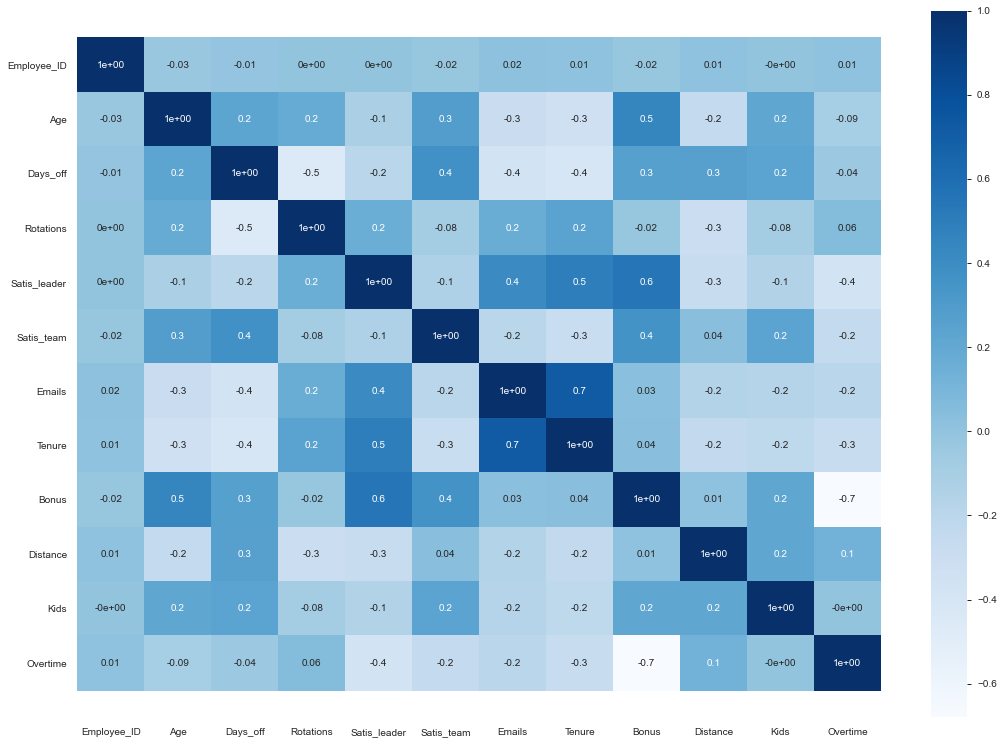

In [5]:
def cor_heatmap(cor):
    plt.figure(figsize=(18,13))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.ylim(plt.ylim()[0] + 0.5, plt.ylim()[1] - 0.5)
    plt.show()

cor_heatmap(train.corr().round(2))

# 2. Preprocessing data

Encoding categorical variables:

In [20]:
## OHE
# for column in ["Department", "Gender"]:
#     train = pd.concat([train.drop(column, axis=1), pd.get_dummies(train[column], prefix=column)], axis=1)
#     test = pd.concat([test.drop(column, axis=1), pd.get_dummies(test[column], prefix=column)], axis=1)

In [6]:
churn_risk_dict = {"low": 0, "medium": 1, "high": 2}
train["Churn_risk"] = train["Churn_risk"].map(churn_risk_dict)

for column in ["Department", "Gender"]:
    pd.concat([train.drop(column, axis=1), pd.get_dummies(train[column], prefix=column)], axis=1)

marital_cols = list(train["Marital_status"].unique())
train = pd.concat([train.drop("Marital_status", axis=1), pd.get_dummies(train["Marital_status"])], axis=1)
test = pd.concat([test.drop("Marital_status", axis=1), pd.get_dummies(test["Marital_status"])], axis=1)

Creating new features:

In [7]:
train["NoKids"] = (train["Kids"] == 0)
test["NoKids"] = (test["Kids"] == 0)

Creating train data:

In [8]:
target = "Churn_risk"

X = train.drop(["Employee_ID", target], axis=1)
y = train[target]

useful_cols = X.columns

In [9]:
cat_Xfeats = ["Department", "Gender"]
cat_Xfeats.extend(marital_cols)
if "NoKids" in useful_cols:
    cat_Xfeats.append("NoKids")
    
rem_Xfeats = list(set(useful_cols) - set(cat_Xfeats))

Dealing with missing values:

In [10]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
X = imputer.fit_transform(X)
X = pd.DataFrame(X, columns=useful_cols)

test_ids = test["Employee_ID"]
test = pd.DataFrame(imputer.transform(test.drop("Employee_ID", axis=1)), columns=useful_cols)

In [11]:
test += test.min().min()

Scaling our data:

In [13]:
X = pd.DataFrame(X, columns=useful_cols)
X += abs(X.min().min())

# 2. Train

Create the Naive Bayes models:

In [14]:
from sklearn.naive_bayes import MultinomialNB, CategoricalNB

clf = MultinomialNB(fit_prior=True);
clf2 = CategoricalNB(fit_prior=True);

Evaluate the model:

In [15]:
%%time

from sklearn.model_selection import StratifiedShuffleSplit

def run_kfold(clfs):
    clf, clf2 = clfs
    
    nfolds = 2000
    print(f"# of Folds: {nfolds}\n")
    
    best_score = 0
    best_weight1 = -1
    
    for w1 in np.arange(0., 1.1, 0.1):
        w1 = round(w1, 2)
        print(f"Weight for MultinomialNB: {w1}")
        weight1 = w1
        weight2 = 1 - weight1

        sss = StratifiedShuffleSplit(n_splits=nfolds, test_size=0.25, random_state=2020)
        outcomes = []
        fold = 0

        for train_indices, test_indices in sss.split(X, y):
            fold += 1
            X_train1, X_test1 = X[rem_Xfeats].values[train_indices], X[rem_Xfeats].values[test_indices]
            X_train2, X_test2 = X[cat_Xfeats].values[train_indices], X[cat_Xfeats].values[test_indices]
            y_train, y_test = y.values[train_indices], y.values[test_indices]

            clf.fit(X_train1, y_train)
            clf2.fit(X_train2, y_train)        

            predictions1 = clf.predict_proba(X_test1)
            predictions2 = clf2.predict_proba(X_test2)
            predictions = (predictions1*weight1 + predictions2*weight2).argmax(axis=1)

            f1 = f1_score(y_test, predictions, average="micro")
            outcomes.append(f1)

        mean_outcome = np.mean(outcomes)
        print(f"\t...mean F1-Score: {mean_outcome}")
        
        if mean_outcome > best_score:
            best_score = mean_outcome
            best_weight1 = weight1
        
    return best_weight1, 1-best_weight1

clfs = [clf, clf2]
weight1, weight2 = run_kfold(clfs)
print(f"weight1 {weight1}, weight2 {weight2}")

# of Folds: 2000

Weight for MultinomialNB: 0.0
	...mean F1-Score: 0.5853076923076924
Weight for MultinomialNB: 0.1
	...mean F1-Score: 0.5892296153846154
Weight for MultinomialNB: 0.2
	...mean F1-Score: 0.6031380769230769
Weight for MultinomialNB: 0.3
	...mean F1-Score: 0.6102196153846154
Weight for MultinomialNB: 0.4
	...mean F1-Score: 0.616455
Weight for MultinomialNB: 0.5
	...mean F1-Score: 0.6207503846153847
Weight for MultinomialNB: 0.6
	...mean F1-Score: 0.6232511538461539
Weight for MultinomialNB: 0.7
	...mean F1-Score: 0.6244761538461538
Weight for MultinomialNB: 0.8
	...mean F1-Score: 0.6240234615384616
Weight for MultinomialNB: 0.9
	...mean F1-Score: 0.6225665384615385
Weight for MultinomialNB: 1.0
	...mean F1-Score: 0.6219446153846153
Wall time: 4min 13s


Train the models:

In [16]:
clf.fit(X[rem_Xfeats], y);
clf2.fit(X[cat_Xfeats], y);

# 3. Predictions

Making predictions:

In [19]:
preds1 = clf.predict_proba(pd.DataFrame(test, columns=useful_cols)[rem_Xfeats])
preds2 = clf2.predict_proba(pd.DataFrame(test, columns=useful_cols)[cat_Xfeats])
preds = (preds1*weight1 + preds2*weight2).argmax(axis=1)

# 4. Writing Submission

Reversing `Churn_risk` encoding:

In [21]:
reverse_churn_risk_dict = {}

for key, value in churn_risk_dict.items():
    reverse_churn_risk_dict[value] = key

preds = pd.Series(preds).map(reverse_churn_risk_dict)

Lazy get submission version:

In [22]:
def find_version():
    """
    Finds automatically the version of the submission. :)
    """
    version = 1
    if len(os.listdir("results")) > 0:
        for file in os.listdir("results"):
            if file.split("_")[1].startswith("version"):
                if int(file.split("_")[1].split("n")[1].split(".")[0]) > version:
                    version = int(file.split("_")[1].split("n")[1].split(".")[0])
        return version + 1
    else:
        return version

Writing submission:

In [23]:
output = pd.DataFrame({"Employee_ID": test_ids, "Churn_risk": preds})
output.to_csv(f'{output_folder}/m20180428_version{find_version()}.csv', index = False)
output.head()

,Employee_ID,Churn_risk
0,1005201,medium
1,1005202,medium
2,1005203,medium
3,1005204,medium
4,1005205,medium
